In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os
from os import walk

from scipy.stats import f_oneway

import pickle
from matplotlib.ticker import MultipleLocator
import matplotlib.dates as mdates
import time

from strats import Strats

val_l = 14340

# FX Subplot

/Users/jordan/Documents/Masters/Dissertation/code/strats.py:83: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  buy['action'] = 'buy'
/Users/jordan/Documents/Masters/Dissertation/code/strats.py:84: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sell['action'] = 'sell'
/Users/jordan/Documents/Masters/Dissertation/code/strats.py:83: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentat

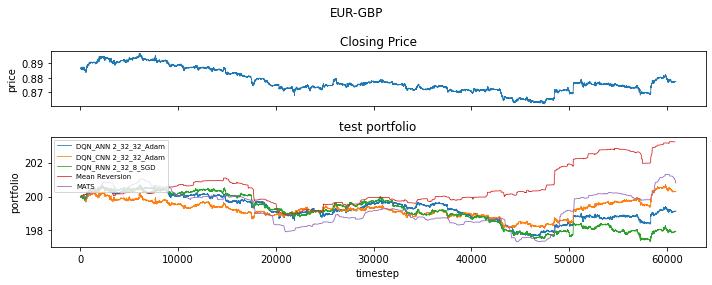

In [51]:
def format_strat(a):
    if 60908 not in a.ts.values:
        a = a.append({'ts':60908, 'portfolio':a.portfolio[len(a)-1]}, ignore_index=True)
    if 0 not in a.ts.values:
        a = a.append({'ts':0, 'portfolio':200}, ignore_index=True).sort_values(by='ts')
    a = a.set_index('ts').reindex(range(0,60909))
    a = a.fillna(method='ffill')
    
    return a.portfolio
    
    

def final_plot(folder):
    f, (ax1, ax2) = plt.subplots(2,1, figsize=(10,4), gridspec_kw={'height_ratios': [1, 2]}, sharex=True)

    stats = pd.DataFrame(columns=['model','avg portfolio', 'portfolio std', 'final portfolio', 'monthly ROI',
                                 'trades', 'avg time'])
    ts = range(60909)

    # Raw data
    raw = pd.read_excel('data/'+folder+'.xlsx', names=['date','open','high','low','close','volume'])
    ax1.plot(ts, raw.close[60680:121589], linewidth=0.8)
    ax1.set_title('Closing Price')
    ax1.set_ylabel('price')

    portfolios = []

    # DQN
    dqns = ['DQN_ANN','DQN_CNN','DQN_RNN']
    #models = ['2_32_32_Adam','1_32_0_Adam','2_32_8_SGD']
    models = ['2_32_32_Adam','2_32_32_Adam','2_32_8_SGD']
    
    for model,dqn in zip(models,dqns):
        if folder=='eur-gbp':
            fname = 'saved_data/'+folder+'/'+dqn+'/test/stats/'+model+'.pickle'
        else:
            fname = 'saved_data/'+folder+'/'+dqn+' '+model+'.pickle'
            
        with open(fname, 'rb') as handle:
            ed0 = pickle.load(handle)
            
        ed0 = ed0[ed0.episode==-2]
        ed0.reset_index(inplace=True)
        label_name = dqn+' '+model
        ax2.plot(ts, ed0.portfolio, label=label_name, linewidth=0.8)
        
        if ed0.portfolio[60908]<200:
            roi = -np.sqrt(abs(ed0.portfolio[60908]-200))
        else:
            roi = np.sqrt(ed0.portfolio[60908]-200)

        stats = stats.append({'model':label_name,
                               'avg portfolio':ed0.portfolio.mean(),
                                'portfolio std':ed0.portfolio.std(),
                                'final portfolio':ed0.portfolio[60908],
                                'monthly ROI':roi,
                              'trades':len(ed0[ed0.action != 0]),
                              'avg time':-(ed0.time - ed0.time.shift(1)).mean()
                               },ignore_index=True)
        portfolios.append(ed0.portfolio)
        
    
    # Popular Trading Strats
    data = ed0
    data = data.rename(columns={'price':'close'})

    start_time = time.time()
    strat = Strats(data)
    strat.MeanReversion()
    hist = strat.run()
    ax2.plot(hist.ts, hist.portfolio, label='Mean Reversion', linewidth=0.8)

    fp = hist.portfolio[ len(hist.portfolio)-1 ]
    stats = stats.append({'model':'Mean Reversion',
                           'avg portfolio':hist.portfolio.mean(),
                            'portfolio std':hist.portfolio.std(),
                            'final portfolio':fp,
                            'monthly ROI':np.sqrt(fp-200),
                          'trades':len(hist),
                          'avg time':(time.time()-start_time)/60909
                           },ignore_index=True)
    portfolios.append(format_strat(hist))
    
    
    start_time = time.time()
    strat.MATS()
    hist = strat.run()
    ax2.plot(hist.ts, hist.portfolio, label='MATS', linewidth=0.8)

    fp = hist.portfolio[ len(hist.portfolio)-1 ]
    stats = stats.append({'model':'MATS',
                           'avg portfolio':hist.portfolio.mean(),
                            'portfolio std':hist.portfolio.std(),
                            'final portfolio':fp,
                            'monthly ROI':np.sqrt(fp-200),
                          'trades':len(hist),
                          'avg time':(time.time()-start_time)/60909
                           },ignore_index=True)
    portfolios.append(format_strat(hist))
    
    ax2.set_title('test portfolio')
    ax2.set_xlabel('timestep')
    ax2.set_ylabel('portfolio')
    ax2.legend(loc='upper left', fontsize='x-small')
    
    f.suptitle(folder.upper())
    f.tight_layout()
    
    save_name = '5_'+''.join(folder.split('-'))
    f.savefig(save_name)
    
    return portfolios
    
portfolios = final_plot('eur-gbp')

In [92]:
stats

,model,avg portfolio,portfolio std,final portfolio,monthly ROI,trades,avg time
0,DQN_ANN 2_32_32_Adam,199.285619,0.719577,199.13074,-0.932341,45105,1.049329
1,DQN_CNN 2_32_32_Adam,199.272562,0.514907,200.30165,0.549227,45274,0.988319
2,DQN_RNN 2_32_8_SGD,199.139497,0.939972,197.95615,-1.429633,45343,1.249501
3,Mean Reversion,200.641609,1.122537,203.21940,1.794269,1464,0.000061
4,MATS,199.320040,0.954756,200.80120,0.895098,1516,0.000086


/Users/jordan/Documents/Masters/Dissertation/code/strats.py:83: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  buy['action'] = 'buy'
/Users/jordan/Documents/Masters/Dissertation/code/strats.py:84: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sell['action'] = 'sell'
/Users/jordan/Documents/Masters/Dissertation/code/strats.py:83: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentat

,fx,f value,p value
0,eur-gbp,27570.747477,0.0
1,eur-usd,32026.555608,0.0
2,eur-chf,26480.734915,0.0


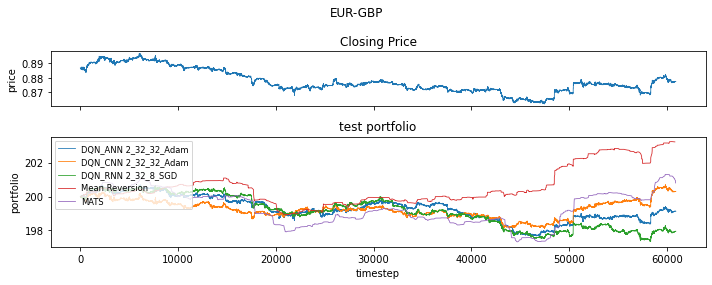

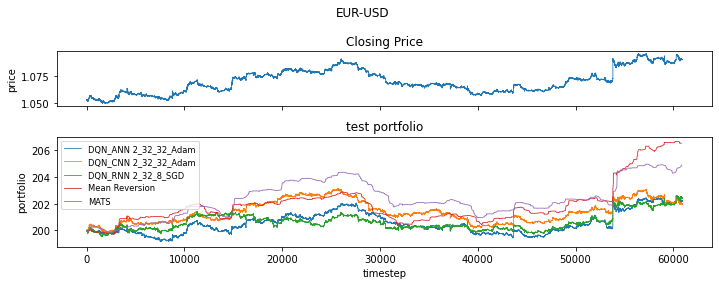

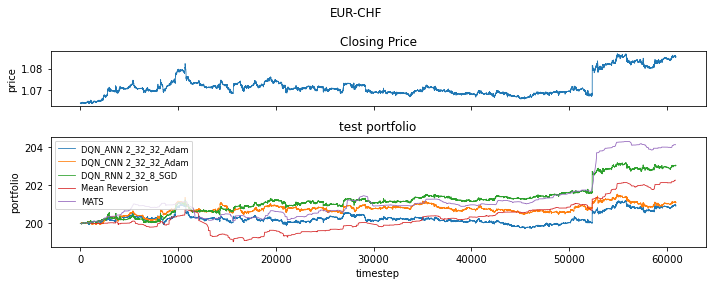

In [50]:
fxs = ['eur-gbp', 'eur-usd', 'eur-chf']
anova = pd.DataFrame(columns=['fx','f value', 'p value'])

for fx in fxs:
    portfolios = final_plot(fx)
    
    F, p = f_oneway(*portfolios)
    anova = anova.append({'fx':fx, 'f value':F, 'p value':p}, ignore_index=True)
    
anova